# Coletando imagens do RPG Maker

.

Este _notebook_ é parte do trabalho [pixel sides](pixel-sides.ipynb). Ele descreve a coleta de imagens provenientes do RPG Maker (diferentes versões)
para gerar um pequeno _dataset_ de imagens de personagens em _pixel art_ no tamanho $(64, 64, 4)$.

Dependendo do formato do RPG Maker, as imagens foram aumentadas/preenchidas para ficarem com $64\times64$.

In [1]:
import os
import numpy as np
import math
from PIL import Image
from io_utils import ensure_folder_structure
from tqdm import tqdm

np.random.seed(42)

target_shape = (64, 64, 4)
label_values = ["0-back", "1-left", "2-front", "3-right"]
TRAIN_PERCENTAGE = 0.85

In [2]:
def crop(image, vertical_tiles, horizontal_tiles, drop_columns=[]):
    """
    Slices a single image with multiple sprites in various, according to the tile width and height
    """

    image_width, image_height = image.size
    tile_height = image_height // vertical_tiles
    tile_width = image_width // horizontal_tiles

    for i in range(vertical_tiles):
        columns_dropped_before = 0

        for j in range(horizontal_tiles):
            # verifica se deveria pular essa sprite por ela ser uma "skip-column"
            # ...necessário porque eg rpgmaker xp mostra o frame "still" 2x (repetido)
            if j in drop_columns:
                columns_dropped_before += 1
                continue

            tile = (j*tile_width, i*tile_height, (j+1)*tile_width, (i+1)*tile_height)
            yield image.crop(tile), i, j - columns_dropped_before


            
def replace_color(data_array, source_color, target_color):
    """
    Replaces a color with another (images use a filled collor instead of transparency)
    """
    red, green, blue, alpha = data_array.T
    color_key_mask = None
    if len(source_color) == 3:
        color_key_mask = (red == source_color[0]) & (green == source_color[1]) & (blue == source_color[2])
    elif len(source_color) == 4:
        color_key_mask = (red == source_color[0]) & (green == source_color[1]) & (blue == source_color[2]) & (alpha == source_color[3])

    data_array[color_key_mask.T] = target_color
    return data_array


def ensure_alpha_is_black_alpha(data_array):
    red, green, blue, alpha = data_array.T
    color_key_mask = alpha == 0
    data_array[color_key_mask.T] = (0, 0, 0, 0)
    return data_array


def shift_image(image, fill_color, dy, dx):
    image = np.roll(image, dy, axis=0)
    image = np.roll(image, dx, axis=1)
    if dy > 0:
        image[:dy, :] = fill_color
    elif dy < 0:
        image[dy:, :] = fill_color
    if dx > 0:
        image[:, :dx] = fill_color
    elif dx < 0:
        image[:, dx:] = fill_color
    return image


In [3]:
image_sources = [
    {
        "source_name": "RPG Maker 2000",
        "source_folder": os.sep.join(["datasets-sources", "RPG Maker 2000 RTP", "CharSet"]),
        "target_folder": os.sep.join(["datasets", "rpg-maker-2000"]),
        "files": ["Actor1.png", "Actor2.png", "Actor3.png", "Actor4.png", "People1.png", "People2.png", "People3.png", "People4.png", "People5.png"],
        "num_tiles": (8, 12),
        "scale_before_padding": (1, 1), #(2, 2)
        "shift_before_padding": (10, 0),
        "color_key": (32, 156, 0),
        "drop_columns": [],
        "row_to_folder_mapping": ["0-back", "3-right", "2-front", "1-left"]
    },
    {
        "source_name": "RPG Maker XP",
        "source_folder": os.sep.join(["datasets-sources", "RPG Maker XP RTP", "Characters"]),
        "target_folder": os.sep.join(["datasets", "rpg-maker-xp"]),
        "files": ["001-Fighter01.png", "002-Fighter02.png", "003-Fighter03.png", "004-Fighter04.png", "005-Fighter05.png", "006-Fighter06.png", "007-Fighter07.png", "008-Fighter08.png", "009-Lancer01.png", "010-Lancer02.png", "011-Lancer03.png", "012-Lancer04.png", "013-Warrior01.png", "014-Warrior02.png", "015-Warrior03.png", "016-Thief01.png", "017-Thief02.png", "018-Thief03.png", "019-Thief04.png", "020-Hunter01.png", "021-Hunter02.png", "022-Hunter03.png", "023-Gunner01.png", "024-Gunner02.png", "025-Cleric01.png", "026-Cleric02.png", "027-Cleric03.png", "028-Cleric04.png", "029-Cleric05.png", "030-Cleric06.png", "031-Cleric07.png", "032-Cleric08.png", "033-Mage01.png", "034-Mage02.png", "035-Mage03.png", "036-Mage04.png", "037-Mage05.png", "038-Mage06.png", "039-Mage07.png", "040-Mage08.png", "041-Mage09.png", "042-King01.png", "043-Queen01.png", "044-Trader01.png", "045-Fortuneteller01.png", "046-Grappler01.png", "047-Grappler02.png", "049-Soldier01.png", "050-Soldier02.png", "101-Civilian01.png", "102-Civilian02.png", "103-Civilian03.png", "104-Civilian04.png", "105-Civilian05.png", "106-Civilian06.png", "107-Civilian07.png", "108-Civilian08.png", "109-Civilian09.png", "110-Civilian10.png", "111-Civilian11.png", "112-Civilian12.png", "113-Civilian13.png", "114-Civilian14.png", "115-Civilian15.png", "116-Civilian16.png", "117-Civilian17.png", "118-Civilian18.png", "119-Civilian19.png", "120-Civilian20.png", "121-Civilian21.png", "122-Civilian22.png", "123-Civilian23.png", "124-Civilian24.png", "126-Noble01.png", "127-Noble02.png", "128-Noble03.png", "129-Noble04.png", "130-Noble05.png", "131-Noble06.png", "132-Noble07.png", "133-Noble08.png", "134-Butler01.png", "135-Maid01.png", "136-Bartender01.png", "137-BunnyGirl01.png", "138-Cook01.png", "139-Clown01.png", "140-Dancer01.png", "141-Bard01.png", "142-Scholar01.png", "143-Farmer01.png", "144-Farmer02.png", "145-Prisoner01.png", "146-Prisoner02.png", "147-Storekeeper01.png", "148-Storekeeper02.png", "149-Captain01.png", "150-Sailor01.png"],
        "num_tiles": (4, 4),
        "scale_before_padding": (1, 1),
        "shift_before_padding": (4, 0),
        "color_key": (255, 255, 255, 0),
        "drop_columns": [0],
        "row_to_folder_mapping": ["2-front", "1-left", "3-right", "0-back"]
    },
    {
        "source_name": "RPG Maker VXAce",
        "source_folder": os.sep.join(["datasets-sources", "RPG Maker VXAce RTP", "Characters"]),
        "target_folder": os.sep.join(["datasets", "rpg-maker-vxace"]),
        "files": ["Actor1.png", "Actor2.png", "Actor3.png", "Actor4.png", "Actor5.png", "Evil.png", "Insane1.png", "Insane2.png", "People1.png", "People2.png", "People3.png", "People4.png", "People5.png", "People6.png", "People7.png", "People8.png", "Spiritual.png"],
        "num_tiles": (8, 12),
        "scale_before_padding": (1, 1), #(1.5, 1.5)
        "shift_before_padding": (10, 0), #(0, 0)
        "color_key": None,
        "drop_columns": [],
        "row_to_folder_mapping": ["2-front", "1-left", "3-right", "0-back"]
    },
    {
        "source_name": "Miscellaneous from Game Character Hub",
        "source_folder": os.sep.join(["datasets-sources", "game-character-hub"]),
        "target_folder": os.sep.join(["datasets", "miscellaneous"]),
        "files": None,
        "num_tiles": (8, 12),
        "scale_before_padding": (1, 1),
        "shift_before_padding": (10, 0),
        "color_key": None,
        "drop_columns": [],
        "row_to_folder_mapping": ["2-front", "1-left", "3-right", "0-back"]
    },
    {
        "source_name": "Miscellaneous in 8x12 fedc",
        "source_folder": os.sep.join(["datasets-sources", "misc-8x12", "fedc"]),
        "target_folder": os.sep.join(["datasets", "miscellaneous"]),
        "files": None,
        "num_tiles": (8, 12),
        "scale_before_padding": (1, 1),
        "shift_before_padding": (10, 0),
        "color_key": None,
        "drop_columns": [],
        "row_to_folder_mapping": ["2-front", "1-left", "3-right", "0-back"]
    },
    {
        "source_name": "Miscellaneous in 8x12 cdfe",
        "source_folder": os.sep.join(["datasets-sources", "misc-8x12", "cdfe"]),
        "target_folder": os.sep.join(["datasets", "miscellaneous"]),
        "files": None,
        "num_tiles": (8, 12),
        "scale_before_padding": (1, 1),
        "shift_before_padding": (10, 0),
        "color_key": None,
        "drop_columns": [],
        "row_to_folder_mapping": ["0-back", "3-right", "2-front", "1-left"]
    },
    {
        "source_name": "Miscellaneous in 3x4 fedc",
        "source_folder": os.sep.join(["datasets-sources", "misc-3x4", "fedc"]),
        "target_folder": os.sep.join(["datasets", "miscellaneous"]),
        "files": None,
        "num_tiles": (4, 3),
        "scale_before_padding": (1, 1),
        "shift_before_padding": (10, 0),
        "color_key": None,
        "drop_columns": [],
        "row_to_folder_mapping": ["2-front", "1-left", "3-right", "0-back"]
    }
]

In [4]:
def generate_dataset_from_spritesheets(source_info, train_file_number_start=0, test_file_number_start=0, train_percentage=1.0):
    files = source_info["files"]
    source_folder = source_info["source_folder"]
    target_folder = source_info["target_folder"]
    vertical_tiles, horizontal_tiles = source_info["num_tiles"]
    scale_before_padding = source_info["scale_before_padding"]
    shift_after_padding = source_info["shift_before_padding"]
    color_key = source_info["color_key"]
    row_to_folder_mapping = source_info["row_to_folder_mapping"]
    drop_columns = source_info["drop_columns"]

    generated_images = []
    generated_labels = []

    files_created_from_this_source = 0

    # if the array "files" is provided, we iterate over them. If not, we pick all files in source_folder
    if files is None:
        files = [name for name in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, name))]

    for file_name in tqdm(files):
        file_path = os.path.join(source_folder, file_name)
        full_image = Image.open(file_path)
        full_image = full_image.convert("RGBA")

        image_width, image_height = full_image.size
        tile_height = image_height // vertical_tiles
        tile_width = image_width // horizontal_tiles

        # updates the number of horizontal tiles after calculating the tile width
        # considering that some column(s) might have been dropped
        horizontal_tiles_after_column_drop = horizontal_tiles - len(drop_columns)

        for (tile, i, j) in crop(full_image, vertical_tiles, horizontal_tiles, drop_columns):
            # 1. redimensiona para que a imagem de um humano adulto tenha 48px de altura
            # NOTA: PIL usa (width, height)
            scaled_size = (int(tile_height*scale_before_padding[0]), int(tile_width*scale_before_padding[1]))
            tile = tile.resize((scaled_size[1], scaled_size[0]), Image.NEAREST)

            # 2. substitui a cor de fundo padrão (se houver) por preto transparente
            data_array = np.array(tile)

            if color_key is not None:
                data_array = replace_color(data_array, color_key, (0, 0, 0, 0))
            data_array = ensure_alpha_is_black_alpha(data_array)

            # 3. preenche de (scaled_size) para (64, 64), que é o tamanho do dataset TinyHero
            padding = ((64 - scaled_size[0]), (64 - scaled_size[1]), 0)
            padding_begin = tuple([value // 2 for value in padding])
            padding_end = tuple([total - begin for (total, begin) in zip(padding, padding_begin)])
            padding = list(zip(padding_begin, padding_end))
            data_array = np.pad(data_array, padding, "constant", constant_values=0)

            # 4. desloca a imagem para que o personagem fique centralizado como no TinyHero
            if abs(shift_after_padding[0]) > 0 or abs(shift_after_padding[1] > 0):
                data_array = shift_image(data_array, (0, 0, 0, 0), *shift_after_padding)

            # 5. salva imagem
            full_image = Image.fromarray(data_array)

            generated_images.append(data_array)
            generated_labels.append(row_to_folder_mapping[i % 4])

            new_file_number = files_created_from_this_source + j + (i // 4) * horizontal_tiles_after_column_drop

            number_of_examples = (horizontal_tiles_after_column_drop * vertical_tiles / 4) * len(files)
            number_of_examples_train = math.ceil(train_percentage * number_of_examples)
            number_of_examples_test = number_of_examples - number_of_examples_train

            if number_of_examples_test == 0:
                new_file_number += train_file_number_start
                ensure_folder_structure(target_folder, row_to_folder_mapping[i % 4])
                new_file_name = "%s.png" % str(new_file_number)
                new_file_path = os.path.join(target_folder, row_to_folder_mapping[i % 4], new_file_name)
            else:
                if new_file_number < number_of_examples_train:
                    train_or_test_folder = "train"
                    new_file_number += train_file_number_start
                else:
                    train_or_test_folder = "test"
                    new_file_number -= number_of_examples_train
                    new_file_number += test_file_number_start
                ensure_folder_structure(target_folder, train_or_test_folder, row_to_folder_mapping[i % 4])
                new_file_name = "%s.png" % str(new_file_number)
                new_file_path = os.path.join(target_folder, train_or_test_folder, row_to_folder_mapping[i % 4], new_file_name)

            # print(new_file_path)
            full_image.save(new_file_path)

        files_created_from_this_source += horizontal_tiles_after_column_drop * (vertical_tiles // 4)

    new_examples = files_created_from_this_source
    new_train_examples = math.ceil(new_examples * train_percentage)
    new_test_examples = new_examples - new_train_examples
    print(f"Processou {len(files)} arquivos gerando {new_examples*4} novas imagens ({new_examples} novos exemplos)")
    return np.array(generated_images), np.array(generated_labels), new_train_examples, new_test_examples



In [5]:
import matplotlib.pyplot as plt

def show_random_sample(sample_images, sample_labels, source_name):
    labels_per_class = np.array([np.where(labels == label)[0] for label in label_values])
    sample_indices = np.array([np.random.choice(from_this_class, 4, replace=False) for from_this_class in labels_per_class]).reshape(-1)
    sample_labels = np.array([sample_labels[indices] for indices in sample_indices])
    sample_images = np.array([sample_images[indices] for indices in sample_indices])

    fig = plt.figure(figsize=(8, 8))
    plt.suptitle(f"Exemplos extraídos de {source_name}")
    fig.subplots_adjust(hspace=.5)
    for i in range(4):
        for j in range(4):
            plt.subplot(4, 4, i*4+j+1)
            plt.imshow(sample_images[i*4+j], interpolation="nearest")
            plt.title(sample_labels[i*4+j])
            plt.axis("off")
    plt.show()

## Gerando _dataset_ de _CharSets_ do RPG Maker 2000/2003

O pacote de _assets_ (RTP) do RPG Maker 2000/2003 possui spritesheets de personagens em que uma imagem possui 8 personagens com cada um tendo 4 linhas (direções) e 3 colunas (quadros de animação de andar). Cada quadro tem dimensões $(24, 32, 3)$ e uma cor de fundo $(32, 156, 0)$ que deve ser considerada como transparente.

100%|██████████| 9/9 [00:01<00:00,  6.82it/s]


Processou 9 arquivos gerando 864 novas imagens (216 novos exemplos)


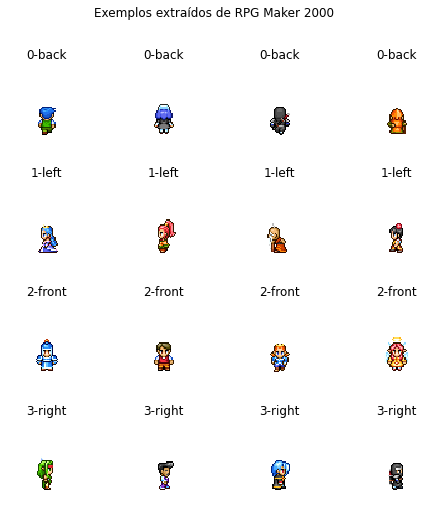

In [55]:
images, labels, _, _ = generate_dataset_from_spritesheets(image_sources[0], 0, 0, train_percentage=TRAIN_PERCENTAGE)
show_random_sample(images, labels, image_sources[0]["source_name"])

## Gerando _dataset_ de _CharSets_ do RPG Maker XP

O pacote de _assets_ (RTP) do RPG Maker XP possui spritesheets de personagens em que uma imagem possui apenas 1 personagem sendo 4 linhas (direções) e 4 colunas (quadros de animação de andar). Cada quadro tem dimensões $(48, 32, 4)$ e fundo transparente.

100%|██████████| 98/98 [00:03<00:00, 26.00it/s]


Processou 98 arquivos gerando 1176 novas imagens (294 novos exemplos)


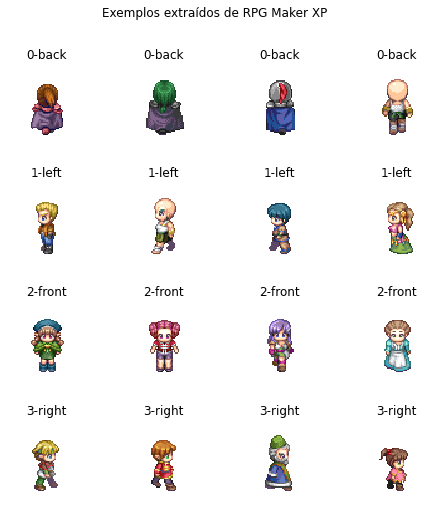

In [6]:
images, labels, _, _ = generate_dataset_from_spritesheets(image_sources[1], 0, 0, TRAIN_PERCENTAGE)
show_random_sample(images, labels, image_sources[1]["source_name"])

## Gerando _dataset_ de _CharSets_ do RPG Maker VX/RPG Maker VX Ace

O pacote de _assets_ (RTP) do RPG Maker VX/RPG Maker VX Ace possui spritesheets de personagens em que uma imagem possui 8 personagens com cada um tendo 4 linhas (direções) e 3 colunas (quadros de animação de andar). Cada quadro tem dimensões $(32, 32, 4)$ e fundo transparente.

100%|██████████| 17/17 [00:02<00:00,  7.05it/s]


Processou 17 arquivos gerando 1632 novas imagens (408 novos exemplos)


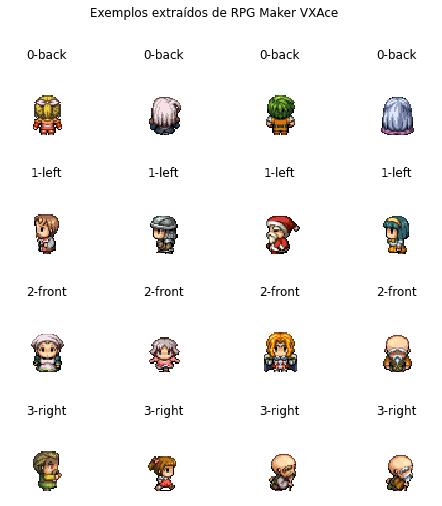

In [57]:
images, labels, _, _ = generate_dataset_from_spritesheets(image_sources[2], 0, 0, TRAIN_PERCENTAGE)
show_random_sample(images, labels, image_sources[2]["source_name"])

## Gerando _dataset_ de uma miscelânea

DESCREVER AQUI.....

100%|██████████| 413/413 [01:10<00:00,  5.87it/s]


Processou 413 arquivos gerando 39648 novas imagens (9912 novos exemplos)


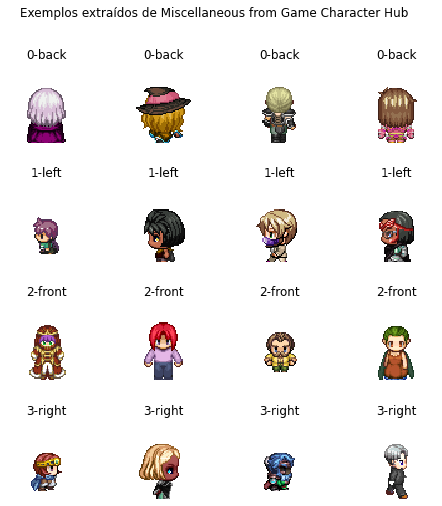

100%|██████████| 77/77 [00:11<00:00,  6.51it/s]


Processou 77 arquivos gerando 7392 novas imagens (1848 novos exemplos)


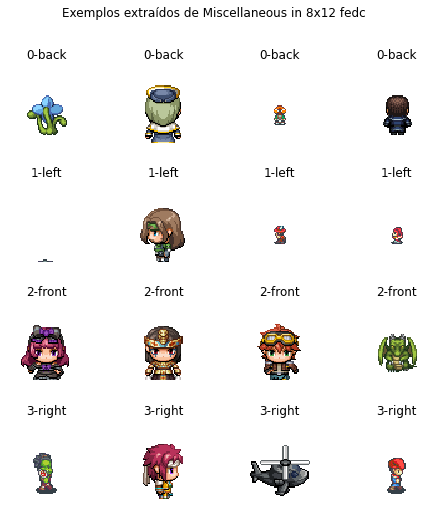

100%|██████████| 17/17 [00:02<00:00,  6.06it/s]


Processou 17 arquivos gerando 1632 novas imagens (408 novos exemplos)


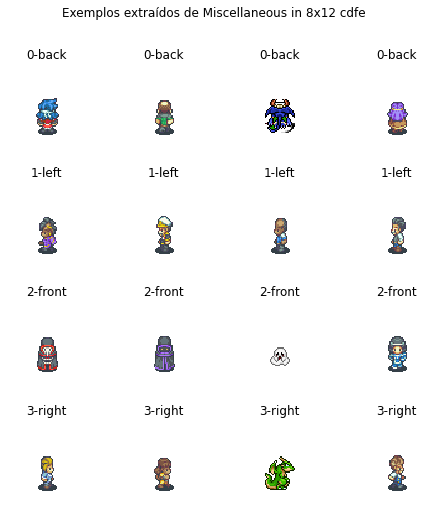

100%|██████████| 68/68 [00:01<00:00, 45.35it/s]


Processou 68 arquivos gerando 816 novas imagens (204 novos exemplos)


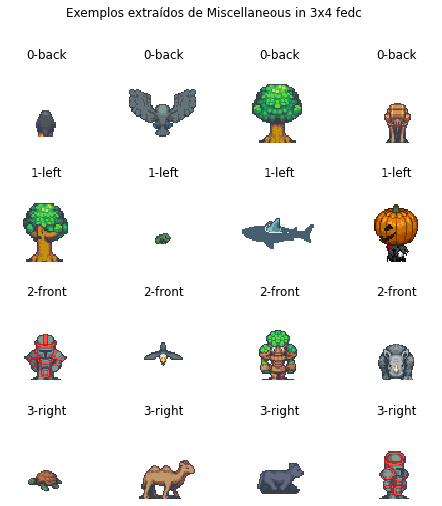

In [16]:
num_train_examples_so_far = 0
num_test_examples_so_far = 0
for index in [3, 4, 5, 6]:
    source_info = image_sources[index]
    images, labels, train_created, test_created = generate_dataset_from_spritesheets(
        source_info,
        num_train_examples_so_far,
        num_test_examples_so_far,
        TRAIN_PERCENTAGE)
    show_random_sample(images, labels, source_info["source_name"])

    num_train_examples_so_far += train_created
    num_test_examples_so_far += test_created

print(f"Criou um total de {num_train_examples_so_far} exemplos de treino e {num_test_examples_so_far} de teste")

## Splitting Tiny Hero dataset between train/test

In [27]:
import os
import re
import shutil
from math import ceil

def value_subtracter(subtrahend):
    def subtract(matchobj):
        new_value = int(matchobj.group(0)) - subtrahend
        return str(new_value)
    return subtract



def move_dataset_files(source_path, train_path, test_path, train_percentage):
    source_files = [os.listdir(os.sep.join([source_path, folder])) for folder in label_values]
    train_file_amount = ceil(train_percentage * len(source_files[0]))
    # print(f"train_file_amount {train_file_amount}")
    
    for i, source_files_per_label in enumerate(source_files):
        ensure_folder_structure(os.sep.join([train_path, label_values[i]]))
        ensure_folder_structure(os.sep.join([test_path, label_values[i]]))

        for file_name in source_files_per_label:
            original_file_number = int(re.search(r"(\d+)\.png", file_name).group(1))
            # print(f"original_file_number {original_file_number}")
            if original_file_number < train_file_amount:
                # goes to train
                destination_path = train_path
            else:
                # goes to test
                destination_path = test_path
                file_name = re.sub(r"(\d+)", value_subtracter(train_file_amount), file_name)

            # print(f"Copying {os.sep.join([source_path, file_name])} to {os.sep.join([destination_path, file_name])}")  
            shutil.copy(os.sep.join([source_path, label_values[i], file_name]), os.sep.join([destination_path, label_values[i], file_name]))
    

In [29]:
from io_utils import ensure_folder_structure, delete_folder

train_path = os.sep.join(["datasets", "tiny-hero", "train"])
test_path = os.sep.join(["datasets", "tiny-hero", "test"])

delete_folder(train_path)
delete_folder(test_path)

move_dataset_files(os.sep.join(["datasets", "tiny-hero"]), train_path, test_path, TRAIN_PERCENTAGE)